In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import pandas as pd
from PIL import Image
import time
import os
import sys
import argparse
import importlib
import tensorflow as tf
import cPickle as pickle

BASE_DIR = os.path.dirname('/home/ubuntu/workspace/frustum-pointnets/scripts/')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'kitti'))
from kitti_util import *
from kitti_object import *
from box_util import *
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
import provider

# Set training configurations
BATCH_SIZE = 32
MODEL_PATH = '/home/ubuntu/workspace/frustum-pointnets/train/log_v1modified-v2box-2/model.ckpt'
GPU_INDEX = 0
NUM_POINT = 1024
MODEL = importlib.import_module('frustum_pointnets_v1')
NUM_CLASSES = 2
NUM_CHANNEL = 4

def draw_point_cloud(ax, points, axes=[0, 1, 2], point_size=0.1, color='black', axes_limits = [
        [-20, 80], # X axis range
        [-30, 30], # Y axis range
        [-3, 3]   # Z axis range
    ]):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    
    axes_str = ['X', 'Y', 'Z']
    ax.grid(False)
    ax.set_aspect('equal')
    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=color, cmap='gray')
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
        
def compute_3d_box_cam2(h, w, l, x, y, z, yaw):
    """
    Return : 3xn in cam2 coordinate
    """
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    corners_3d_cam2 += np.vstack([x, y, z])
    return corners_3d_cam2

def draw_box(ax, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        ax.plot(*vertices[:, connection], c=color, lw=0.5)

/home/ubuntu/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarni

In [2]:
def read_detection(path, gt=False):
    df = pd.read_csv(path, header=None, sep=' ')
    if gt:
        df.columns = ['type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top',
                    'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']
    else:
        df.columns = ['type', 'truncated', 'occluded', 'alpha', 'bbox_left', 'bbox_top',
                    'bbox_right', 'bbox_bottom', 'height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y', 'score']
    df = df[df['type']=='Car']
    df.reset_index(drop=True, inplace=True)
    return df

In [3]:
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = MODEL.get_model(pointclouds_pl, one_hot_vec_pl,
                is_training_pl)
            loss = MODEL.get_loss(labels_pl, centers_pl,
                heading_class_label_pl, heading_residual_label_pl,
                size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

def inference(sess, ops, pc, one_hot_vec):
    ep = ops['end_points']
    feed_dict = {ops['pointclouds_pl']: pc,
                 ops['one_hot_vec_pl']: one_hot_vec,
                 ops['is_training_pl']: False}

    batch_logits, batch_centers, \
    batch_heading_scores, batch_heading_residuals, \
    batch_size_scores, batch_size_residuals = \
        sess.run([ops['logits'], ops['center'],
            ep['heading_scores'], ep['heading_residuals'],
            ep['size_scores'], ep['size_residuals']],
            feed_dict=feed_dict)

    heading_cls = np.argmax(batch_heading_scores, 1) # B
    size_cls = np.argmax(batch_size_scores, 1) # B
    heading_res = np.array([batch_heading_residuals[i,heading_cls[i]] for i in range(len(batch_heading_residuals))])
    size_res = np.vstack([batch_size_residuals[i,size_cls[i],:] for i in range(len(batch_size_residuals))])
    
    return np.argmax(batch_logits, 2), batch_centers, heading_cls, heading_res, size_cls, size_res

In [4]:
sess, ops = get_session_and_ops(batch_size=None, num_point=NUM_POINT)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from /home/ubuntu/workspace/frustum-pointnets/train/log_v1m

In [5]:
class_dict = {1: 'Pedestrian', 2: 'Car', 3: 'Cyclist'}
g_type2onehotclass = {'Car': 0, 'Pedestrian': 1, 'Cyclist': 2}

df_2d = pd.read_csv('/home/ubuntu/workspace/frustum-pointnets/kitti/rgb_detections/rgb_detection_val.txt', sep=' ', header=None)
df_2d.columns = ['img_id', 'type', 'score', 'xmin', 'ymin', 'xmax', 'ymax']
df_2d['img_id'] = df_2d['img_id'].apply(lambda x: int(x.split('/')[-1].split('.')[0]))
df_2d['type'] = df_2d['type'].apply(lambda x: class_dict[x])
df_2d = df_2d[df_2d['score']>0.5]

df_bev = pd.read_csv('/home/ubuntu/workspace/BEV_detection/detection_result/detection_result.csv')
print(len(df_bev))

11322


In [6]:
def read_detection_2d(img_id):
    df_2d_this = df_2d[df_2d['img_id']==img_id]
    df_2d_this.reset_index(inplace=True, drop=True)
    return np.array(df_2d_this['type']), np.array(df_2d_this[['xmin', 'ymin', 'xmax', 'ymax']])
    
def read_detection_bev(img_id):
    df_bev_this = df_bev[df_bev['img_id']==img_id]
    df_bev_this.reset_index(inplace=True, drop=True)
    return np.array(df_bev_this[['xmin', 'ymin', 'xmax', 'ymax']])

In [123]:
import yaml

DETECTION_2D_MODEL_PATH = '/home/ubuntu/workspace/models/research/object_detection/faster_rcnn_resnet101_kitti_2018_01_28/frozen_inference_graph.pb'
DETECTION_BEV_MODEL_PATH = '/home/ubuntu/workspace/models/research/object_detection/kitti_detection_graph/frozen_inference_graph.pb'
LABEL_DICT_PATH = 'kitti_label_dict.txt'

class Kitti_Detector_2d():
    def __init__(self, model_path, label_dict_path):
        self.__load_model(model_path, label_dict_path)
        print('model loaded')

    def __load_model(self, model_path, label_dict_path):
        # load tf model
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(model_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        config = tf.ConfigProto()
        config.gpu_options.allow_growth= True

        with self.detection_graph.as_default():
            self.sess = tf.Session(config=config, graph=self.detection_graph)
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')

        # load label_dict
        with open(label_dict_path, 'r') as f:
            self.label_dict = yaml.load(f)
        
        # warmup
        self.detect_image(np.ones((600, 600, 3), dtype=np.uint8))

    def detect_image(self, image_rgb):
        image_w, image_h = image_rgb.shape[1], image_rgb.shape[0]
#         image_rgb = cv2.resize(image_rgb, None, fx=1.0, fy=1.25)

        # Actual detection.
        t = time.time()
        (boxes, scores, classes) = self.sess.run(
          [self.detection_boxes, self.detection_scores, self.detection_classes],
          feed_dict={self.image_tensor: np.expand_dims(image_rgb, axis=0)})
        print('detection time :', time.time()-t)
        
        types = []
        boxes_2d = []
        for i in range(len(boxes[0])):
            if scores[0, i] < 0.5:
                break
            types += [self.label_dict[classes[0, i]]]
            xmin = boxes[0, i, 1] * image_w
            ymin = boxes[0, i, 0] * image_h
            xmax = boxes[0, i, 3] * image_w
            ymax = boxes[0, i, 2] * image_h
            boxes_2d += [(xmin, ymin, xmax, ymax)]
        return types, np.array(boxes_2d)

class Kitti_Detector_bev():
    def __init__(self, model_path):
        self.__load_model(model_path)
        print('model loaded')

    def __load_model(self, model_path):
        # load tf model
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(model_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        config = tf.ConfigProto()
        config.gpu_options.allow_growth= True

        with self.detection_graph.as_default():
            self.sess = tf.Session(config=config, graph=self.detection_graph)
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')

        # warmup
        self.detect_image(np.ones((600, 600, 3), dtype=np.uint8))

    def detect_image(self, image_rgb):
        image_w, image_h = image_rgb.shape[1], image_rgb.shape[0]

        # Actual detection.
        t = time.time()
        (boxes, scores, classes) = self.sess.run(
          [self.detection_boxes, self.detection_scores, self.detection_classes],
          feed_dict={self.image_tensor: np.expand_dims(image_rgb, axis=0)})
        print('detection time :', time.time()-t)
        
        boxes_2d = []
        for i in range(len(boxes[0])):
            if scores[0, i] < 0.5:
                break
            xmin = 40.0-boxes[0, i, 2]*40.0
            xmax = 40.0-boxes[0, i, 0]*40.0
            ymin = 20.0-boxes[0, i, 3]*40.0
            ymax = 20.0-boxes[0, i, 1]*40.0
            boxes_2d += [(xmin, ymin, xmax, ymax)]
        return np.array(boxes_2d)

In [124]:
kitti_detector_2d = Kitti_Detector_2d(DETECTION_2D_MODEL_PATH, LABEL_DICT_PATH)
kitti_detector_bev = Kitti_Detector_bev(DETECTION_BEV_MODEL_PATH)

('detection time :', 2.1952998638153076)
model loaded
('detection time :', 2.5430071353912354)
model loaded


In [7]:
def point_cloud_2_top(points,
                      res=0.1,
                      zres=1.0,
                      side_range=(-20., 20-0.05),  # left-most to right-most
                      fwd_range=(0., 40.-0.05),  # back-most to forward-most
                      height_range=(-2., 0.),  # bottom-most to upper-most
                      ):
    """ Creates an birds eye view representation of the point cloud data for MV3D.
    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        res:        (float)
                    Desired resolution in metres to use. Each output pixel will
                    represent an square region res x res in size.
        zres:        (float)
                    Desired resolution on Z-axis in metres to use.
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        height_range: (tuple of two floats)
                    (min, max) heights (in metres) relative to the origin.
                    All height values will be clipped to this min and max value,
                    such that anything below min will be truncated to min, and
                    the same for values above max.
    Returns:
        numpy array encoding height features , density and intensity.
    """
    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = int((side_range[1] - side_range[0]) / res)
    y_max = int((fwd_range[1] - fwd_range[0]) / res)
    z_max = int((height_range[1] - height_range[0]) / zres)
    top = np.zeros([y_max+1, x_max+1, z_max+1], dtype=np.float32)

    # FILTER - To return only indices of points within desired cube
    # Three filters for: Front-to-back, side-to-side, and height ranges
    # Note left side is positive y axis in LIDAR coordinates 
    filt = (points[:, 0] > fwd_range[0]) & (points[:, 0] < fwd_range[1]) & \
            (points[:, 1] > -side_range[1]) & (points[:, 1] < -side_range[0])
    
    points = points.compress(filt, axis=0)
    
    for i, height in enumerate(np.arange(height_range[0], height_range[1], zres)):

        z_filt = (points[:, 2] >= height) & (points[:, 2] < height + zres)

        # KEEPERS
        points_ = points.compress(z_filt, axis=0)

        # CONVERT TO PIXEL POSITION VALUES - Based on resolution
        x_img = (-points_[:, 1] / res).astype(np.int32)  # x axis is -y in LIDAR
        y_img = (-points_[:, 0] / res).astype(np.int32)  # y axis is -x in LIDAR

        # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
        # floor & ceil used to prevent anything being rounded to below 0 after
        # shift
        np.add(x_img, -int(np.floor(side_range[0] / res)), out=x_img)
        np.add(y_img, int(np.floor(fwd_range[1] / res)), out=y_img)

        # FILL PIXEL VALUES IN IMAGE ARRAY
        top[y_img, x_img, i] = points_[:, 2] - height_range[0]

        # max_intensity = np.max(prs[idx])
        top[y_img, x_img, z_max] = points_[:, 3]
        
    return (top / np.max(top) * 255).astype(np.uint8)

from shapely.geometry import Polygon
def boxes_intersect(corners1, corners2):
    rect1 = Polygon(corners1[:4, [0, 2]])
    rect2 = Polygon(corners2[:4, [0, 2]])
    return rect1.intersects(rect2)

115213
(25797, 0.014340877532958984)
('detection time :', 0.0886240005493164)
0.00291180610657
0.00301790237427
(25, 0.0480649471282959)
(15, 0.004854917526245117)


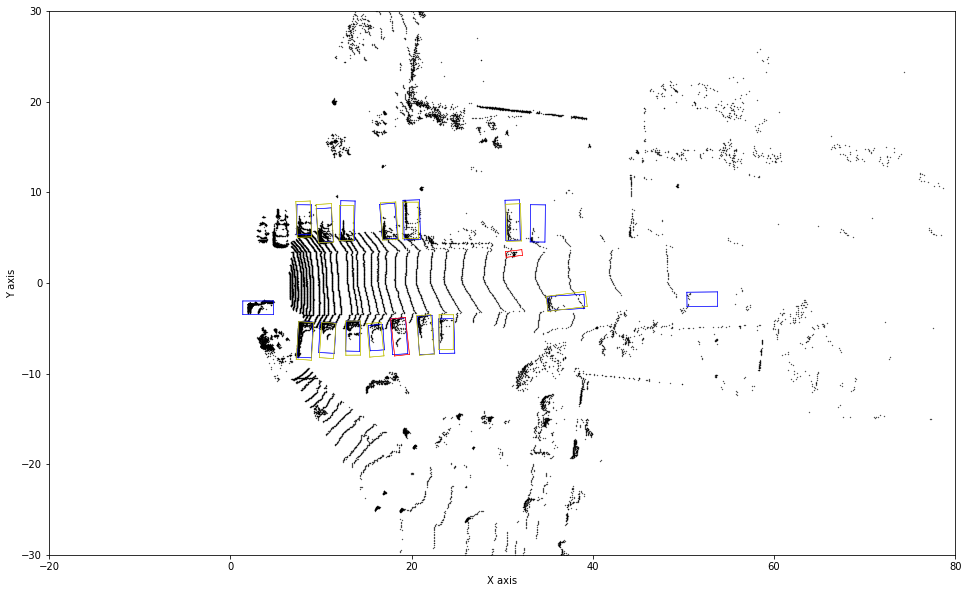

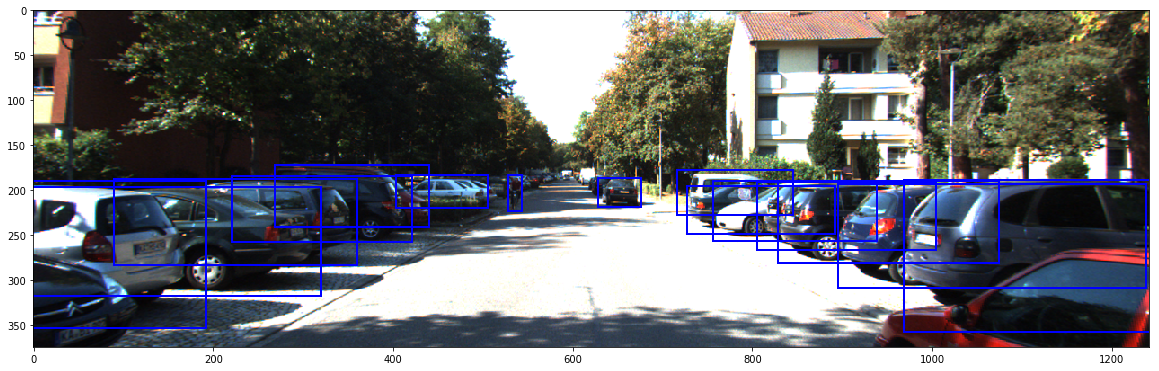

In [161]:
img_id = 2615

calib = Calibration('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/calib/%06d.txt'%img_id)
path = '/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/velodyne/%06d.bin'%img_id
points = np.fromfile(path, dtype=np.float32).reshape(-1, 4)
print(len(points))
points = points.compress(points[:, 0]>=0, axis=0)
df_gt = read_detection('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/label_2/%06d.txt'%img_id, True)
# df_gt = read_detection('/home/ubuntu/workspace/frustum-pointnets/train/detection_results_v1/data/%06d.txt'%img_id)

img = np.array(Image.open('/home/ubuntu/workspace/frustum-pointnets/dataset/KITTI/object/training/image_2/%06d.png'%img_id))
img_h, img_w, _ = img.shape

thr = 0.2

ti = time.time()
pts_2d = calib.project_velo_to_image(points[:, :3])
fov_inds = (pts_2d[:,0]<img_w+1000) & (pts_2d[:,0]>=-1000) & (pts_2d[:,1]<img_h) & (pts_2d[:,1]>=0)
points = points.compress(fov_inds, axis=0)
pc_image_coord = pts_2d.compress(fov_inds, axis=0)
print(len(points), time.time()-ti)

all_sample_points = []
one_hot_vecs = []
frustum_angles = []

# show bev results
boxes_2d = kitti_detector_bev.detect_image(point_cloud_2_top(points))
ti = time.time()
for box_2d in boxes_2d:
    xmin, ymin, xmax, ymax = box_2d
    frustum_angle = -1 * np.arctan2((xmin+xmax)/2.0, -(ymin+ymax)/2.0)
    box_fov_inds = (points[:, 0]>xmin-thr) & (points[:, 0]<xmax+thr) & (points[:, 1]>ymin-thr) & (points[:, 1]<ymax+thr)
    box_fov_velo = points.compress(box_fov_inds, axis=0)
    if len(box_fov_velo) <= 10:
        continue
    box_fov_cam2 = calib.project_velo_to_rect(box_fov_velo[:, :3])
    box_fov_cam2 = np.concatenate([box_fov_cam2, box_fov_velo[:, -1:]], axis=-1)
    box_fov_cam2_center_view = provider.rotate_pc_along_y(box_fov_cam2, frustum_angle+np.pi/2)
    idx = np.random.choice(len(box_fov_cam2_center_view), NUM_POINT, replace=True)
    sample_points = box_fov_cam2_center_view[idx]
    one_hot_vec = np.zeros(3)
    one_hot_vec[0] = 1
    all_sample_points += [sample_points]
    one_hot_vecs += [one_hot_vec]
    frustum_angles += [frustum_angle]
print(time.time()-ti)
n_det_bev = len(frustum_angles)

types, boxes_2d = read_detection_2d(img_id)#kitti_detector_2d.detect_image(img)
ti = time.time()
for i in range(len(boxes_2d)):
    typ = types[i]
    xmin, ymin, xmax, ymax = boxes_2d[i]
    box_fov_inds = (pc_image_coord[:,0]<xmax) & (pc_image_coord[:,0]>=xmin) & (pc_image_coord[:,1]<ymax) & (pc_image_coord[:,1]>=ymin)
    box_fov_velo = points.compress(box_fov_inds, axis=0)
    if len(box_fov_velo)<=10:
        continue
    box2d_center = np.array([(xmin+xmax)/2.0, (ymin+ymax)/2.0])
    uvdepth = np.zeros((1,3))
    uvdepth[0,:2] = box2d_center
    uvdepth[0,2] = 20 # some random depth
    box2d_center_rect = calib.project_image_to_rect(uvdepth)
    frustum_angle = -1 * np.arctan2(box2d_center_rect[0,2], box2d_center_rect[0,0])
    box_fov_cam2 = calib.project_velo_to_rect(box_fov_velo[:, :3])
    box_fov_cam2 = np.concatenate([box_fov_cam2, box_fov_velo[:, -1:]], axis=-1)
    box_fov_cam2_center_view = provider.rotate_pc_along_y(box_fov_cam2, frustum_angle+np.pi/2)
    idx = np.random.choice(len(box_fov_cam2_center_view), NUM_POINT, replace=True)
    sample_points = box_fov_cam2_center_view[idx]
    one_hot_vec = np.zeros(3)
    one_hot_vec[g_type2onehotclass[typ]] = 1
    all_sample_points += [sample_points]
    one_hot_vecs += [one_hot_vec]
    frustum_angles += [frustum_angle]
print(time.time()-ti)
    
ti = time.time()
if len(one_hot_vecs)>0:
    batch_logits, batch_centers, batch_heading_scores, batch_heading_residuals, batch_size_scores, \
    batch_size_residuals = inference(sess, ops, np.array(all_sample_points), np.array(one_hot_vecs))
print(len(one_hot_vecs), time.time()-ti)

ti = time.time()
# boxes_3d_cam2 = []
# for i in range(len(one_hot_vecs)):
#     h,w,l,tx,ty,tz,ry = provider.from_prediction_to_label_format(batch_centers[i], batch_heading_scores[i], batch_heading_residuals[i], batch_size_scores[i], batch_size_residuals[i], frustum_angles[i]+np.pi/2)
#     corners_3d_cam2 = compute_3d_box_cam2(h,w,l,tx,ty,tz,ry).T # 8x3
#     add = True
#     if i >= n_det_bev:
#         for box_3d_ in boxes_3d_cam2:
#             if boxes_intersect(corners_3d_cam2, box_3d_):
#                 add = False
#                 break
#     if add:
#         boxes_3d_cam2 += [corners_3d_cam2]
boxes_3d_cam2_bev = []
boxes_3d_cam2_2d = []
for i in range(len(one_hot_vecs)):
    h,w,l,tx,ty,tz,ry = provider.from_prediction_to_label_format(batch_centers[i], batch_heading_scores[i], batch_heading_residuals[i], batch_size_scores[i], batch_size_residuals[i], frustum_angles[i]+np.pi/2)
    corners_3d_cam2 = compute_3d_box_cam2(h,w,l,tx,ty,tz,ry).T # 8x3
    if i < n_det_bev:
        boxes_3d_cam2_bev += [corners_3d_cam2]
    else:
        boxes_3d_cam2_2d += [corners_3d_cam2]
boxes_3d_cam2_bev_ = np.array(boxes_3d_cam2_bev)
min_z_bev = np.min(boxes_3d_cam2_bev_[:, :, -1], axis=-1)
min_z_idx_bev = np.argsort(min_z_bev)
boxes_3d_cam2_bev_ = boxes_3d_cam2_bev_[min_z_idx_bev] # sort the boxes from small z to large z
min_z_bev = min_z_bev[min_z_idx_bev]
min_z_idx_2d = np.argsort(np.min(np.array(boxes_3d_cam2_2d)[:, :, -1], axis=-1))
start = 0
for i_2d in min_z_idx_2d:
    add = True
    for i_bev in range(start, n_det_bev):
        # if the 2d box's max z is smaller than the next bev box's min z, then intersection is impossible
        if np.max(boxes_3d_cam2_2d[i_2d][:, -1]) < min_z_bev[i_bev]:
            break
        # if the 2d box's min z is greater than the next bev box's max z, increase search start point
        elif np.max(boxes_3d_cam2_bev_[i_bev][:, -1]) < np.min(boxes_3d_cam2_2d[i_2d][:, -1]):
            start += 1
        # if intersection is impossible in x axis
        elif np.max(boxes_3d_cam2_bev_[i_bev][:, 0]) < np.min(boxes_3d_cam2_2d[i_2d][:, 0]) or \
             np.min(boxes_3d_cam2_bev_[i_bev][:, 0]) > np.max(boxes_3d_cam2_2d[i_2d][:, 0]):
            continue
        elif boxes_intersect(boxes_3d_cam2_2d[i_2d], boxes_3d_cam2_bev_[i_bev]):
            add = False
            start = i_bev
            break
    if add:
        boxes_3d_cam2_bev += [boxes_3d_cam2_2d[i_2d]]
boxes_3d_cam2 = boxes_3d_cam2_bev
print(len(boxes_3d_cam2), time.time()-ti)

fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points, axes=[0, 1])
# show gt boxes
for o in range(len(df_gt)):
    corners_3d_cam2 = compute_3d_box_cam2(*df_gt.loc[o, ['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])
    draw_box(ax, calib.project_rect_to_velo(corners_3d_cam2.T).T, axes=[0, 1], color='b')
    
for i, box_3d_cam2 in enumerate(boxes_3d_cam2):
    color = 'y' if i < n_det_bev else 'r'
    box_3d = calib.project_rect_to_velo(box_3d_cam2)
    draw_box(ax, box_3d.T, axes=[0, 1], color=color)
fig, ax = plt.subplots(figsize=(20, 10))
for box_3d_cam2 in boxes_3d_cam2:
    box2d = calib.project_rect_to_image(box_3d_cam2)
    xmin = np.min(box2d[:, 0])
    xmax = np.max(box2d[:, 0])
    ymin = np.min(box2d[:, 1])
    ymax = np.max(box2d[:, 1])
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, lw=2, color='b', fill=False)
    ax.add_patch(rect)
plt.imshow(img)

In [107]:
np.max(boxes_3d_cam2_2d[i_2d][:, -1])

39.10475981733712

In [102]:
np.min(boxes_3d_cam2_bev_[:, :, -1], axis=-1)

array([ 1.24385256,  6.97708721,  9.22511351,  9.4191566 , 11.70114279,
       12.36193378, 14.76716951, 16.40274528, 18.81192304, 20.29873525,
       22.78698023, 30.13800991, 34.60252481])

In [80]:
min_z_idx_bev

array([ 1.1251742 ,  7.02495249,  9.18971953,  9.59178742, 11.71805797,
       12.44420983, 14.76196507, 16.34078962, 18.68944216, 20.36159246,
       22.69244386, 30.11440543, 34.63094698])

In [78]:
ti = time.time()
np.array(boxes_3d_cam2_bev)[min_z_idx_bev]
time.time()-ti

0.00020384788513183594

In [34]:
ti = time.time()
b = 25
inference(sess, ops, np.repeat(sample_points[np.newaxis,:], b, axis=0), np.repeat(one_hot_vec[np.newaxis,:], b, axis=0))
time.time()-ti

0.052993059158325195